<a href="https://colab.research.google.com/github/koffqq/rehab-exercise/blob/main/course_ai_rehab_hc_2024_tutorial_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial 8 Causal Analysis Tutorial using `causal-learn` and `DoWhy`

In this tutorial, we will explore causal analysis using two powerful Python libraries: [`causal-learn`](https://github.com/py-why/causal-learn), and [`DoWhy`](https://www.pywhy.org/dowhy/v0.11.1/index.html). These tools help us identify causal relationships in datasets, which is critical for understanding how different factors influence one another and for making informed decisions.

The goal of this notebook is to show how causal discovery methods can work with `DoWhy`. We use discovery methods from `causal-learn` repo. As we will see, causal discovery methods require appropriate assumptions for the correctness guarantees, adn thus there will be variance across results returned by different methods in practice. These methods, however, may be combined usefully with domain knowledge to construct the final causal graph.

### Key Libraries
- **Causal-learn**: A Python library for causal discovery, useful for understanding causal relationships.
- **DoWhy**: A Python library for causal inference, useful for understanding causal effects.
- **Tigramite**: A [Python library](https://github.com/jakobrunge/tigramite) designed to estimate time-lagged causal relationships from multivariate time series data.

### Setup
First, let's install the necessary libraries:

In [ ]:
!pip install causal-learn
!pip install dowhy
!pip install graphviz
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.3 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


### Note: Installing Graphviz for Visualization
If you encounter an error related to `dot` not being found in your local machine, make sure that Graphviz is installed and available in your system's PATH.

1. Install Graphviz:
   - Using `conda`:
     ```bash
     conda install graphviz
     ```
   - Or using `pip`:
     ```bash
     pip install graphviz
     ```
   - Or download from [Graphviz official website](https://graphviz.gitlab.io/download/).

2. Add Graphviz to the System PATH (for Windows users):
   - Find the Graphviz installation folder (e.g., `C:\Program Files\Graphviz\bin`).
   - Add this path to your environment variables.

After completing these steps, restart your Jupyter Notebook and try running the code again.

In [ ]:
## Importing Libraries
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

### Utility Function
Define a utility function to draw the directed acyclic graph.

In [ ]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

### Sachs Dataset
The dataset consists of the simultaneous measurements of 11 phosphorylated proteins and phospholipids derived from thousands of individual primary immune system cells, subjected to both general and specific molecular interventions (Sachs et al., 2005).

The specifications of the dataset are as follows - - Number of nodes: 11 - Number of arcs: 17 - Number of parameters: 178 - Average Markov blanket size: 3.09 - Average degree: 3.09 - Maximum in-degree: 3 - Number of instances: 7466

In [ ]:
# Load the data
from causallearn.utils.Dataset import load_dataset

data_sachs, labels = load_dataset("sachs")

print(data_sachs.shape)
print(labels)

(7466, 11)
['raf', 'mek', 'plc', 'pip2', 'pip3', 'erk', 'akt', 'pka', 'pkc', 'p38', 'jnk']


### Causal Discovery using `causal-learn`
We use the causal-learn library to perform causal discovery on the breast cancer dataset. We use three methods for causal discovery here: PC, GES and LiNGAM. These methods are widely used and do not take much time to run. Hence, these are ideal for an introduction to the topic. Causal-learn provides a comprehensive list of well-tested causal-discovery methods, and readers are welcome to explore.

The documentation for the methods used are as follows:
- [PC](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html)  
- [GES ](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Score-based%20causal%20discovery%20methods/GES.html)
- [LiNGAM](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Causal%20discovery%20methods%20based%20on%20constrained%20functional%20causal%20models/lingam.html#ica-based-lingam)

More methods could be found in the [causal-learn documentation](https://causal-learn.readthedocs.io/en/latest/).

We first try the PC algorithm and see how it works.

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

data = data_sachs
cg = pc(data, alpha=0.05, indep_test='fisherz')
# alpha is the significance level of the conditional independence tests


  0%|          | 0/11 [00:00<?, ?it/s]

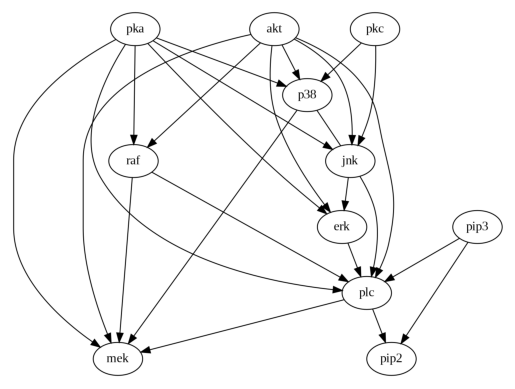

In [ ]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

Then we have a causal graph discovered by PC. Let us also try GES to see its result.

In [ ]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data)

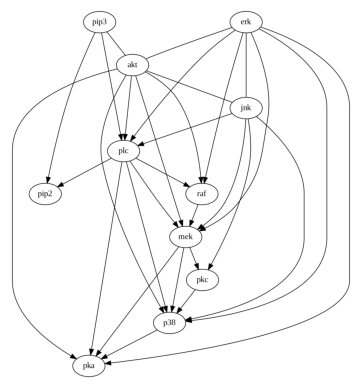

In [ ]:
# Visualization using pydot

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

Well, these two results are different, which is not rare when applying causal discovery on real-world dataset, since the required assumptions on the data-generating process are hard to verify.

In addition, the graphs returned by PC and GES are CPDAGs instead of DAGs, so it is possible to have undirected edges (e.g., the result returned by GES). Thus, causal effect estimataion is difficult for those methods, since there may be absence of backdoor, instrumental or frontdoor variables. In order to get a DAG, we decide to try LiNGAM on our dataset.

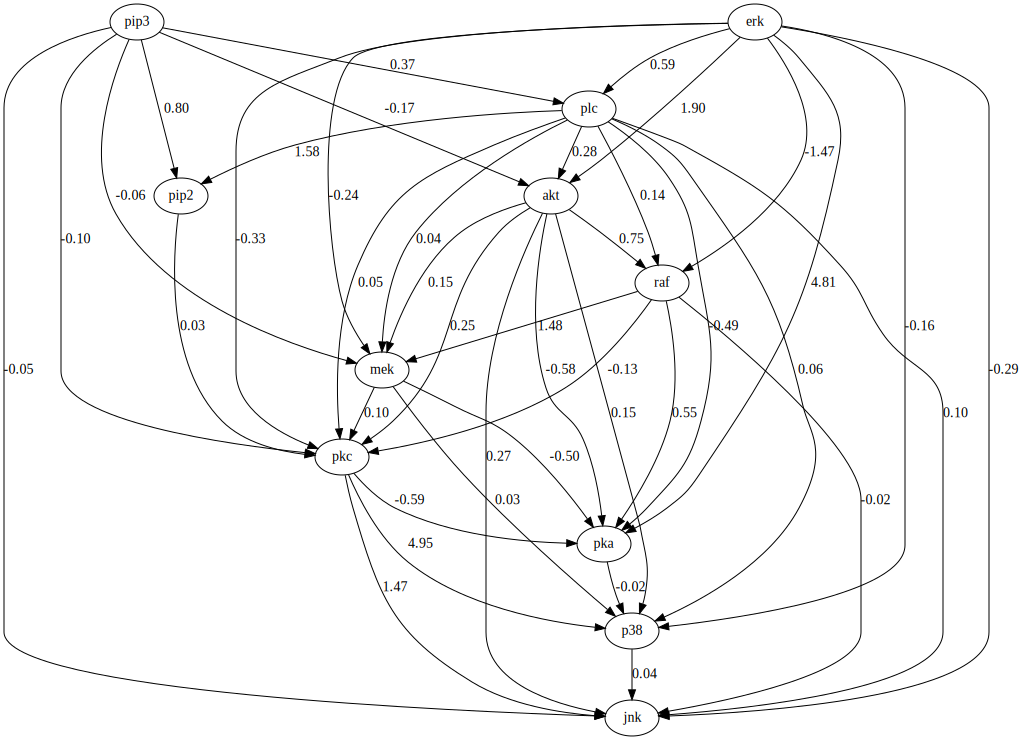

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

Now we have a DAG and are ready to estimate the causal effects based on that.

### Estimate causal effects using Linear Regression
Now let us see the estimate of causal effect of "PIP2" on "PKC".

In [ ]:
# Obtain valid dot format
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

data_df = pd.DataFrame(data=data, columns=labels)

In [ ]:
# Define Causal Model
model_est=CausalModel(
        data = data_df,
        treatment='pip2',
        outcome='pkc',
        graph=str_to_dot(graph_dot.source))

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


In [ ]:
# Identification
identified_estimand = model_est.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                    
───────(E[pkc|plc,pip3])
d[pip₂]                 
Estimand assumption 1, Unconfoundedness: If U→{pip2} and U→pkc then P(pkc|pip2,plc,pip3,U) = P(pkc|pip2,plc,pip3)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# Estimation
estimate = model_est.estimate_effect(identified_estimand,
                    method_name="backdoor.linear_regression",
                    control_value=0,
                    treatment_value=1,
                    confidence_intervals=True,
                    test_significance=True)

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

In [ ]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 0.0339718922845158


## Time Series Causal Analysis using `tigramite`
For those who are interested in time series causal analysis, please refer to [tigramite online tutorials](https://github.com/jakobrunge/tigramite/tree/master/tutorials) for more detailed materials in causal discovery and inference on multivariate time series data

## Exercise

Please use above analysis toolbox "causal-learn" and "dowhy" for `Breast Cancer` dataset which is available from scikit-learn.

This dataset contains several features that describe characteristics of cell nuclei, and the goal is to understand potential causal relationships between these features and a diagnosis outcome.

In [ ]:
# Loading the Breast Cancer dataset from scikit-learn
from sklearn.datasets import load_breast_cancer

# Load dataset
data_bc = load_breast_cancer()
X = pd.DataFrame(data_bc.data, columns=data_bc.feature_names)
y = pd.Series(data_bc.target, name='diagnosis')

# Combine features and target into a single DataFrame
data_bc = pd.concat([X, y], axis=1)
print(data_bc.shape)
data_bc.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
labels = [f'{col}' for i, col in enumerate(data_bc.columns)]
data = data_bc.to_numpy()

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

data = data
cg = pc(data, alpha=0.05, indep_test='fisherz')
# alpha is the significance level of the conditional independence tests

  0%|          | 0/31 [00:00<?, ?it/s]

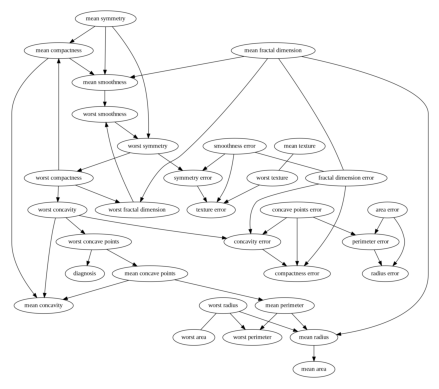

In [ ]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

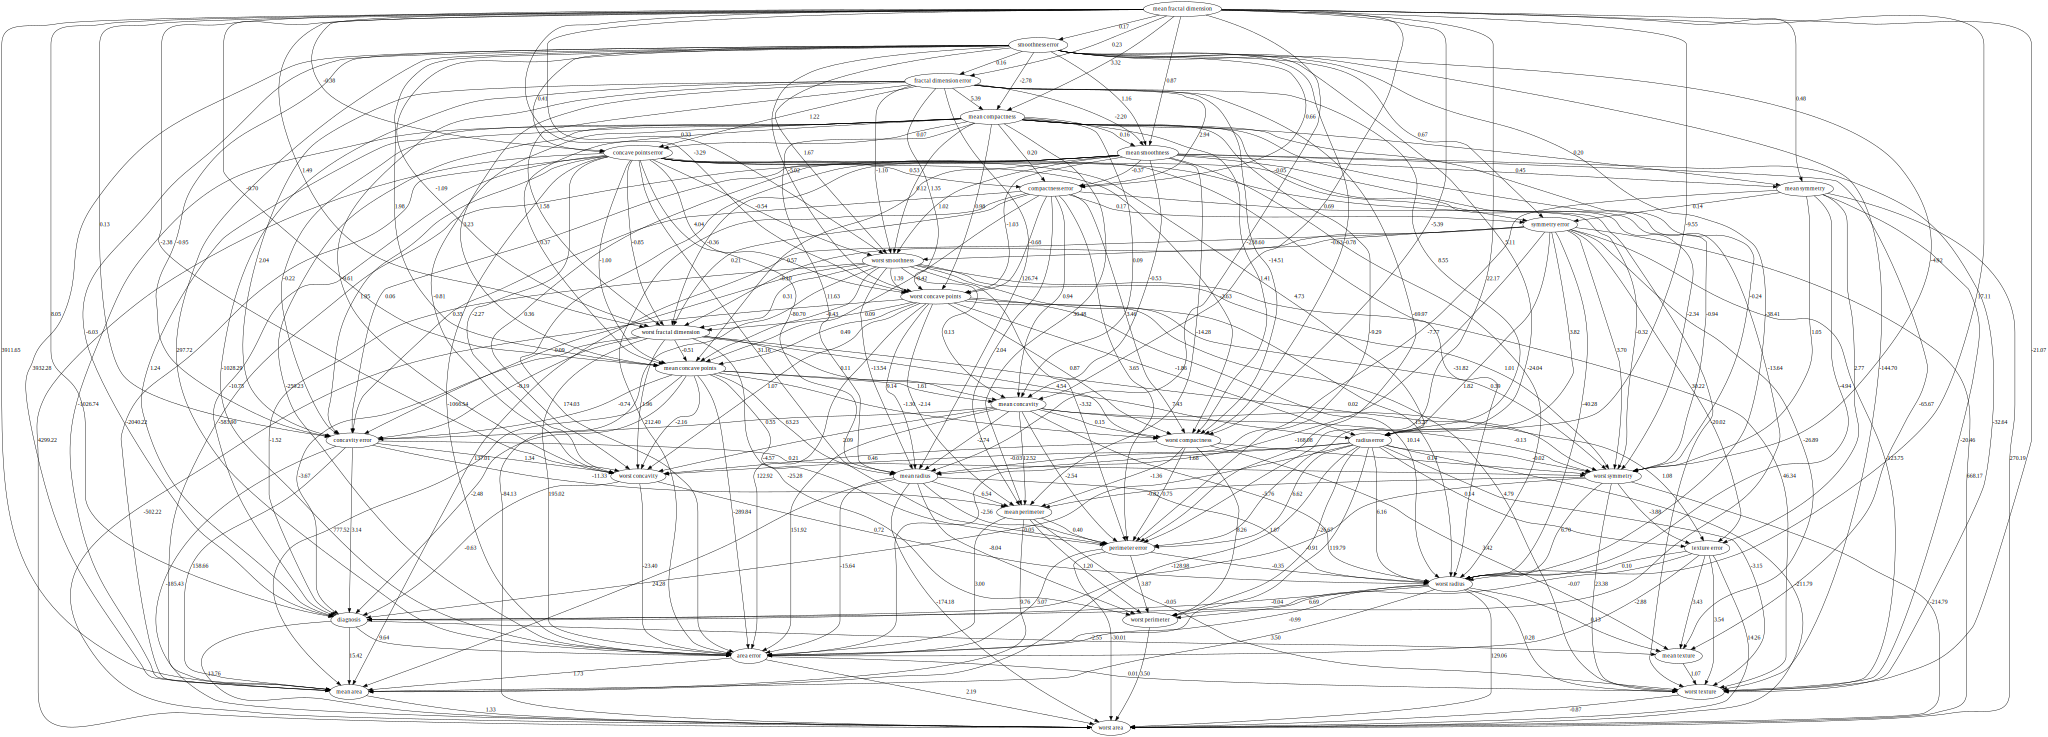

In [ ]:
# try LiNGAM
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

In [ ]:
# Obtain valid dot format
graph_dot = make_graph(model.adjacency_matrix_, labels=labels)

data_df = pd.DataFrame(data=data, columns=labels)

In [ ]:
# Define Causal Model, see the estimate of causal effect of "radius error" on "mean radius".
model_est=CausalModel(
        data = data_df,
        treatment='radius error',
        outcome='mean radius',
        graph=str_to_dot(graph_dot.source))

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


In [ ]:
# Identification
identified_estimand = model_est.identify_effect(proceed_when_unidentifiable=False)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                                           ↪
───────────────(E[mean radius|symmetry error,worst concave points,mean fractal dimension,fractal d ↪
d[radius error]                                                                                    ↪

↪                                                                           
↪ imension error,concave points error,mean concave points,smoothness error])
↪                                                                           
Estimand assumption 1, Unconfoundedness: If U→{radius error} and U→mean radius then P(mean radius|radius error,symmetry error,worst concave points,mean fractal dimension,fractal dimension error,concave points error,mean concave points,smoothness error,U) = P(mean radius|radius error,symmetry error,worst concave points,mean fractal dimension,fractal dimen

In [ ]:
# Estimation
estimate = model_est.estimate_effect(identified_estimand,
                    method_name="backdoor.linear_regression",
                    control_value=0,
                    treatment_value=1,
                    confidence_intervals=True,
                    test_significance=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be

In [ ]:
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 2.0218404514349917
